## 0. Data Download
 - 출처: 서울과기대 임경태 교수
 - 데이터출처: NIA VQA데이터 2021 (유클리드, 임경태 구축)

In [1]:
!nvidia-smi

Fri Dec  8 10:59:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers==3.4
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.8/170.8 kB 19.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 58.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects
  Using cached sentencepiece-0.1.99-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


In [3]:
import os
import gdown
pwd = os.getcwd()
pwd_list = os.listdir(os.getcwd())
parent_folder = os.path.abspath(os.path.join(pwd, os.pardir))

if "data" not in os.listdir(parent_folder): # Check the data folder is available. If download dataset from google drive
    google_path = 'https://drive.google.com/uc?id='
    file_id = '1VJz-OhIpUIXNyc12-qNoocw_AvnCRLpk'
    output_name = 'data.zip'
    gdown.download(google_path+file_id,output_name,quiet=False)
    !mkdir ../data
    !unzip data.zip
    !mv dataset ../data/

Downloading...
From: https://drive.google.com/uc?id=1VJz-OhIpUIXNyc12-qNoocw_AvnCRLpk
To: /content/data.zip
100%|██████████| 10.7G/10.7G [03:13<00:00, 55.4MB/s]


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: dataset/train_images/f033afde6ad242a68d10fe8a1f575588.jpg  
  inflating: dataset/train_images/f033b3c88b714d15943fc9fc71551ded.jpeg  
  inflating: dataset/train_images/f034201a32c14dfcaaabbabe0fd7e511.jpg  
  inflating: dataset/train_images/f0349505ae2e41af90279bdcf95d5d6e.jpeg  
  inflating: dataset/train_images/f03582e401b148f286b22abd0b3a46d0.jpg  
  inflating: dataset/train_images/f03617d9b29b4def81a093a7b92be27c.jpg  
  inflating: dataset/train_images/f0367035cbd648a3af70e285bbf14f6d.jpg  
  inflating: dataset/train_images/f036f5209ab24232978f170b2e58d735.jpg  
  inflating: dataset/train_images/f037e2c34fc14274abf1bcaf8278a1c2.jpg  
  inflating: dataset/train_images/f03919d5c00443819af77da0f7cd1403.jpg  
  inflating: dataset/train_images/f03a63c8563b4ca3ae242375a5dcdb5c.jpg  
  inflating: dataset/train_images/f03a72ad832a4957a13bd2681e8b64dc.jpg  
  inflating: dataset/train_images/f03aaa40ce954d949cdb8d98cad0a42e.jpg  
  inflating: 

## 1. 사용할 라이브러리 및 GPU사용 체크

In [ ]:
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import transformers
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from PIL import Image


torch.backends.cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## 2. Data전처리를 위한 파이토치 데이터셋 선언

In [5]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, data, answer_list, max_token, transform=None):

        self.tokenizer = tokenizer
        self.data = data
        self.max_token = max_token
        self.answer_list = answer_list
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        question = self.data['QUESTION'][index] #질문
        answer = self.data['ANSWER'][index]  #응답
        img_loc = self.data['FILE_LOC'][index] #사진파일

        #BERT기반의 Tokenizer로 질문을 tokenize한다.
        tokenized = self.tokenizer.encode_plus("".join(question),
                                     None,
                                     add_special_tokens=True,
                                     max_length = self.max_token,
                                     truncation=True,
                                     pad_to_max_length = True)


        #BERT기반의 Tokenize한 질문의 결과를 변수에 저장
        ids = tokenized['input_ids']
        mask = tokenized['attention_mask']
        image = Image.open(img_loc).convert('RGB')  #이미지 데이터를 RGB형태로 읽음 질문을 tokenize한다.
        image = self.transform(image)  #이미지 데이터의 크기 및 각도등을 변경

        answer_ids = self.answer_list[self.answer_list['ANSWER']==answer].index #응답을 숫자 index로 변경, e.g.) "예"-->0 "아니요" --> 1
        if len(answer_ids)==0:
            answer_ids = self.answer_list[self.answer_list['ANSWER']=="예"].index

        #전처리가 끝난 질의, 응답, 이미지 데이터를 반환
        return {'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'answer': torch.tensor(answer_ids, dtype=torch.long),
                'image': image}




## 3. 학습을위한 모델 선언

In [6]:
class VQAModel(nn.Module):
    def __init__(self, num_target, dim_i, dim_q, dim_h=1024):
        super(VQAModel, self).__init__()

        #The BERT model: 질문 --> Vector 처리를 위한 XLM-Roberta모델 활용
        self.bert = transformers.XLMRobertaModel.from_pretrained('xlm-roberta-base')

        #Backbone: 이미지 --> Vector 처리를 위해 ResNet50을 활용
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, dim_i)
        self.i_relu = nn.ReLU()
        self.i_drop = nn.Dropout(0.2)

        #classfier: MLP기반의 분류기를 생성
        self.linear1 = nn.Linear(dim_i, dim_h)
        self.q_relu = nn.ReLU()
        self.linear2 = nn.Linear(dim_h, num_target)
        self.q_drop = nn.Dropout(0.2)


    def forward(self, idx, mask, image):

        #_, q_f = self.bert(idx, mask) #질문을 Bert를 활용해 Vector화
        outputs = self.bert(idx, mask) #질문을 Bert를 활용해 Vector화
        i_f = self.i_drop(self.resnet(image)) # 이미지를 resnet을 활용해 Vector화
        q_f = outputs.pooler_output
        uni_f = i_f*q_f #이미지와 질문 vector를 point-wise연산을 통해 통합 vector생성

        return self.linear2(self.q_relu(self.linear1(uni_f))) #MLP classfier로 답변 예측


## 4. 학습과 테스트를 위한 함수 선언

In [7]:
def train_fn(model, train_loader, criterion, optimizer, device):

    total_count_correct = 0
    total_num_example = 0
    total_loss = []

    model.train()
    for idx, batch in tqdm(enumerate(train_loader), total=len(train_loader), leave=False): #학습 데이터를 batch size만큼씩 읽어옴
        optimizer.zero_grad()

        imgs = batch['image'].to(device)  #이미지
        q_bert_ids = batch['ids'].to(device) #질문
        q_bert_mask = batch['mask'].to(device)
        answers = batch['answer'].to(device) #응답
        answers = answers.squeeze()

        outputs = model(q_bert_ids, q_bert_mask, imgs) #모델에 이미지, 질문, 응답을 넣음
        loss = criterion(outputs, answers) #예측된 답변과 실제 정답과 비교하여 lossr계산

        loss.backward(loss)
        optimizer.step()

        predicted = torch.argmax(outputs, dim=1)
        count_correct = np.count_nonzero((np.array(predicted.cpu())==np.array(answers.cpu())) == True) #정답갯수를 계산
        total_count_correct += count_correct
        total_num_example += answers.size(0)
        total_loss.append(loss.item())

    print("LOSS:", str(sum(total_loss)/total_num_example) + " Accuracy: " + str(total_count_correct/total_num_example) )



def test_fn(model, test_loader, data_frame, device):

    model.eval()
    predicted_list = []

    with torch.no_grad():
        for idx, batch in tqdm(enumerate(test_loader), total=len(test_loader), leave=False):
            optimizer.zero_grad()

            imgs = batch['image'].to(device)
            q_bert_ids = batch['ids'].to(device)
            q_bert_mask = batch['mask'].to(device)
            answers = batch['answer'].to(device)
            answers = answers.squeeze()

            outputs = model(q_bert_ids, q_bert_mask, imgs)
            predicted = torch.argmax(outputs, dim=1)  #예측된 정답
            predicted_list.extend(predicted.tolist()) #예측된 정답을 list로 저장

        predicted_df = pd.DataFrame(predicted_list, columns=['predicted_idx'])
        data_frame['predicted_idx'] = predicted_df['predicted_idx']
    return data_frame  #예측된 정답을 포함한 테스트 데이터를 반환


## 5. 데이터 읽기 및 모델생성 그리고 학습 및 평가

In [8]:
MODEL_FILE = './model97.tar'
MODEL_FILE = None

test_csv_file = '../data/dataset/output_sample.csv'
test_img_folder = '../data/dataset/test_images/'
test_df = pd.read_csv(test_csv_file)
test_df['FILE_LOC'] = test_df['IMAGE_NAME'].apply(lambda x: test_img_folder+x)
test_df.head(3)

if MODEL_FILE is not None:
    checkpoint = torch.load(MODEL_FILE)
    train_df = checkpoint["train_df"]
    answer_list = checkpoint["answer_list"]
    model = VQAModel(num_target=len(answer_list), dim_q=768, dim_i=768, dim_h=1024)
    model = torch.nn.DataParallel(model)
    model = model.to(DEVICE)

    optimizer = optim.AdamW(model.parameters(), lr=0.00002)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


else:

    # Set files
    train_csv_file = '../data/dataset/train.csv'
    train_img_folder = '../data/dataset/train_images/'
    dev_csv_file = '../data/dataset/train.csv'
    dev_img_folder = '../data/dataset/train_images/'

    # Set table
    train_df = pd.read_csv(train_csv_file)

    # Set file locations
    train_df['FILE_LOC'] = train_df['IMAGE_NAME'].apply(lambda x: train_img_folder+x)
    train_df.head(3)

    # Set answer list
    answer_list = train_df['ANSWER'].value_counts() #Extract and count all answers as a DataFrame by decending order
    answer_list.head(3)
    answer_list = answer_list.reset_index() #set a new index
    answer_list.columns=['ANSWER', 'COUNT'] #set colum names
    topK = 1000 #how many candidate answers will be listed in?
    answer_list = answer_list[:topK-1]

    model = VQAModel(num_target=len(answer_list), dim_q=768, dim_i=768, dim_h=1024)
    model = torch.nn.DataParallel(model)
    model = model.to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=0.00002)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 22.0MB/s]


In [9]:
tokenizer = transformers.XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')  #질의를 처리할 BERT Tokenizer선언
#이미지 전처리를 위한 이미지 크기 변환 및 각도조정을 위한 transform 선언
transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [10]:
train_dataset = VQADataset(tokenizer, train_df, answer_list, 30, transform) #학습데이터 전처리
train_loader = DataLoader(dataset=train_dataset, batch_size=30, num_workers=4, shuffle=True, pin_memory=True)

In [11]:
test_dataset = VQADataset(tokenizer, test_df, answer_list, 30, transform) #테스트데이터 전처리
test_loader = DataLoader(dataset=test_dataset, batch_size=30, num_workers=4, shuffle=False, pin_memory=True)

In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
for epoch in range(1):  #학습셋을 이용해 100번 학습
    train_fn(model, train_loader, criterion, optimizer, DEVICE)

  0%|          | 0/18557 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_le

LOSS: 0.04763867317109098 Accuracy: 0.5630998550378392


In [14]:
pred_df = test_fn(model, test_loader, test_df, DEVICE)  #test데이터를 이용해 답변예측

  0%|          | 0/4257 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_len

In [23]:
pred_df.head(150) #예측된 답변 확인

,IMAGE_NAME,QUESTION,ANSWER,FILE_LOC,predicted_idx
0,4062090787d44673b1bd5828f4cdf1fe.jpg,빨간색 조형물에 쓰여 있는 숫자는 무엇입니까?,예,../data/dataset/test_images/4062090787d44673b1...,0
1,4062090787d44673b1bd5828f4cdf1fe.jpg,빨간색 조형물 왼쪽에 있는 간판은 무슨 색입니까?,노란색,../data/dataset/test_images/4062090787d44673b1...,8
2,4062090787d44673b1bd5828f4cdf1fe.jpg,가로등 뒤에 있는 주유소의 이름은 무엇입니까?,예,../data/dataset/test_images/4062090787d44673b1...,0
3,4062090787d44673b1bd5828f4cdf1fe.jpg,기둥에 부착된 조형물은 몇 가지 색입니까?,2,../data/dataset/test_images/4062090787d44673b1...,4
4,4062090787d44673b1bd5828f4cdf1fe.jpg,노란색 조형물에 쓰여 있는 글씨는 무엇입니까?,예,../data/dataset/test_images/4062090787d44673b1...,0
...,...,...,...,...,...
145,16179b27d76249be95907bff97e9d2a5.jpg,어떤 지역을 안내하고 있습니까?,예,../data/dataset/test_images/16179b27d76249be95...,0
146,16179b27d76249be95907bff97e9d2a5.jpg,도로에 트럭은 몇 대입니까?,1대,../data/dataset/test_images/16179b27d76249be95...,24
147,86daf72bd89248b3abe6f6b7a890918a.jpg,차선은 무슨 색입니까,흰색,../data/dataset/test_images/86daf72bd89248b3ab...,3
148,86daf72bd89248b3abe6f6b7a890918a.jpg,도로 오른쪽에 있는 선은 실선입니까,예,../data/dataset/test_images/86daf72bd89248b3ab...,0


In [16]:
pred_df['ANSWER'] = pred_df['predicted_idx'].apply(lambda x: answer_list.iloc[x]['ANSWER']) #예측된답변이 답변의 index번호이므로 index를 이용해 답변텍스트 반환

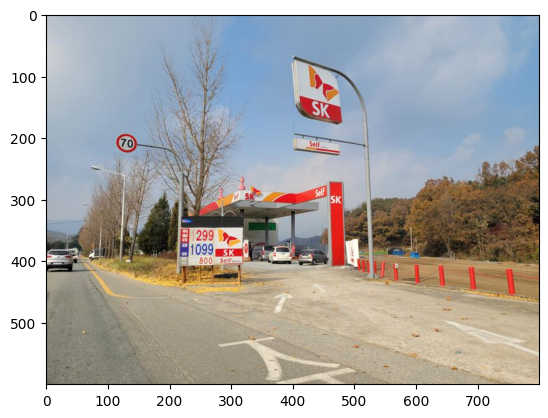

In [17]:
plt.imshow(plt.imread(pred_df.iloc[16]["FILE_LOC"]))

In [18]:
pred_df.groupby('ANSWER').sum()

<ipython-input-18-0fa9d74c2c7f>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_df.groupby('ANSWER').sum()


,predicted_idx
ANSWER,
1,6195
1개,76399
1대,48216
1명,945
1층,16356
...,...
플라스틱,16308
현대,19536
형광등,9675


In [19]:
pred_df[['IMAGE_NAME', 'QUESTION', 'ANSWER']].to_csv('output_last.csv', index = False) #파일로저장

In [20]:
def save_checkpoint(state, filename="model_last.tar"):
    model.module.bert.save_pretrained("./roberta-large-355M")
    tokenizer.save_pretrained("./roberta-large-355M")
    print("=> Saving checkpoint")
    torch.save(state, filename)

checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "train_df": train_df,
    "answer_list": answer_list
}
save_checkpoint(checkpoint)

=> Saving checkpoint


In [21]:
def answering(model, img_file, question, tokenizer, answer_list, device):

    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

    model.eval()
    img = transform(Image.open(img_file).convert("RGB")).unsqueeze(0)
    img = img.to(device)

    encoded = tokenizer.encode_plus("".join(question),
                                     None,
                                     add_special_tokens=True,
                                     max_length = 30,
                                     truncation=True,
                                     pad_to_max_length = True)

    with torch.no_grad():
        ids, mask = encoded['input_ids'], encoded['attention_mask']
        ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
        mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0).to(device)
        output = model(ids, mask, img)
        #print(output)

        predicted = torch.argmax(output, dim=1).item()
        print(predicted)
        answer = answer_list['ANSWER'][predicted]

    return answer

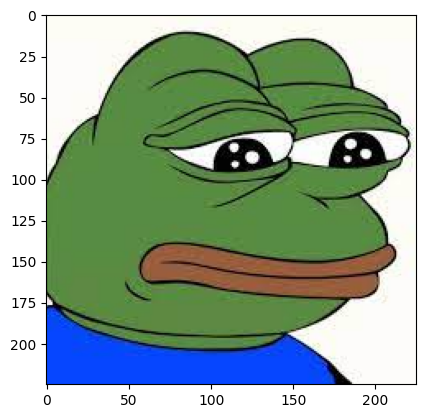

In [24]:
plt.imshow(plt.imread("/content/다운로드.jpeg"))

In [26]:
answering(model, '/content/다운로드.jpeg', '당신은 개구리 입니까?', tokenizer, answer_list, DEVICE)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1


'네'